# Lab05 Exercises #1

UW Geospatial Data Analysis  
CEE498/CEWA599  
David Shean  

## Objectives
* Learn how to inspect, read and write raster data
* Develop a more intuitive understanding of raster transforms, window/extent operations
* Understand raster visualization approaches, contrast stretching and interpolation settings
* Perform common raster band math operations (e.g., NDVI) using NumPy
* Perform quantitative raster analysis using value thresholds and binary masks
* Understand programmatic Landsat-8 archive access and download

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

import rasterio as rio
import rasterio.plot
from osgeo import gdal

#Useful package to add dynamic scalebar to matplotlib images
from matplotlib_scalebar.scalebar import ScaleBar

## Part 0: Run Landsat data download notebook, set path to data directory
* 05_Raster1_LS8_download.ipynb

In [ ]:
pwd

'/home/jovyan/gda_course_2022_solutions/modules/05_Raster1_GDAL_rasterio_LS8'

In [ ]:
#Open accompanying notebook and Run All Cells
#Alternatively, can run from this notebook, which should preserve variables/state
#%run ./05_Raster1_LS8_download.ipynb

In [ ]:
#Set path to local directory with downloaded images
imgdir = 'LS8_sample'

In [ ]:
#Pre-identified cloud-free Image IDs used for the lab
#Summer 2018
img_id1 = 'LC08_L1TP_046027_20180818_20180829_01_T1'
#Winter 2018
img_id2 = 'LC08_L1TP_046027_20181224_20190129_01_T1'

In [ ]:
#Define image to use (can set this to switch to winter image)
img = img_id1

In [ ]:
#Specify filenames for different bands we will need for the lab
#Check table from background section to see wavelengths of each band number

#Red
r_fn = os.path.join(imgdir, img+'_B4.TIF')
#Green
g_fn = os.path.join(imgdir, img+'_B3.TIF')
#Blue
b_fn = os.path.join(imgdir, img+'_B2.TIF')
#Near-Infrared
nir_fn = os.path.join(imgdir, img+'_B5.TIF')
#Shortwave-Infrared
swir_fn = os.path.join(imgdir, img+'_B6.TIF')
#Panchromatic
p_fn = os.path.join(imgdir, img+'_B8.TIF')

In [ ]:
#Specify filenames for different bands we will need for the lab
#Check table from background section to see wavelengths of each band number
tir_fn = os.path.join(imgdir, img+'_B10.TIF')
print(tir_fn)

LS8_sample/LC08_L1TP_046027_20180818_20180829_01_T1_B10.TIF


## Part 1: Raster basics

### Open the downloaded image from disk
* Since we already downloaded these images locally, let's just open a local file
* Let's use of the red band (B4) TIF file
    * We already defined the `r_fn` above, so this should be easy
* Don't use the `with` construct - store the opened dataset in a variable, so we can use in other cells

In [ ]:
print(r_fn)
src = rio.open(r_fn)

### What is the CRS of the dataset?
* Look familiar?  The `fiona` functionality underlying `rasterio` (also used by `geopandas`) was mostly written by the same author (Sean Gilles, https://github.com/sgillies). 
* If you don't recognize it by now, take a minute to look up this EPSG code

### What is the raster extent (bounds) of the dataset in projected coordinates?
* Note that this is not a simple python `list` object, but a special rasterio [`BoundingBox` object](https://rasterio.readthedocs.io/en/latest/api/rasterio.coords.html#rasterio.coords.BoundingBox) with attributes for `left`, `bottom`, etc.
    * This helps you avoid mixing up order of values that correspond to `(min_x, min_y, max_x, max_y)`
    * Note that other API and utilities may use different order (e.g., `min_x, max_x, min_y, max_y`)

### How many bands are there in this dataset?
* Check the approprate rasterio dataset attribute

### Review the profile and metadata record
* Inspect the rasterio `profile` and `meta` attributes, which should return dictionaries for all metadata

### OK, let's read the raster data into a NumPy array and preview
* Store the output in a new variable called `r`
* Use default read options for now, don't read as masked array
* What band number should we use here? 
    * This dataset is for the red Landsat multispectral band, which is band #4 (B4)
    * But each Landsat band is stored as a separate TIF file (remember your dataset band `count` attribute)
    * So using rasterio `read`, which band do you need to load?
    * Note: If you omit the band number, rasterio will return a 3D NumPy array with an additional dimension

<class 'numpy.ndarray'>


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

### What are the dimensions of the NumPy array?  
* Compare this with the rasterio dataset `width` and `height` attributes
    * Look carefully, as these are slightly different
    * Hopefully this offers a reminder about the ordering of NumPy indices, with (row, col) representing (y,x) dimensions

### What is the uncompressed filesize of this array in Megabytes?
* You can compute this using the array data type and dimensions
    * Can check with the NumPy array `nbytes` attribute
* This is how much RAM the image is occupying on the system
* How does this compare with the file size of the `*B4.TIF` file on disk (from earlier `ls -alh`)?
    * If different, why might they be different? ✍️

### Create a plot of the image
* Earlier we used the `rio.plot.show()` convenience function for plotting a dataset, which is a wrapper around the standard matplotlib `imshow()`.  Here, let's create a figure/axes and use matplotlib `imshow` directly.
* Use the `gray` color ramp
* If using `%matplotlib widget` backend, I recommend you start with `f,ax = plt.subplots()`, which will create a new figure in the cell (otherwise, your `imshow` output could end up in an earlier figure).

In [ ]:
#%matplotlib widget

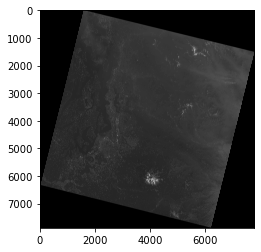

* Note that the Landsat-8 image appears "rotated" relative to the axes
    * Why is this? ✍️
* Note the array coordinate system (where is the (0,0) origin)
* Interactively look at coordinates and the 12-bit values (digital number [DN]) as you move your mouse over the image
    * The DN is the pixel value from the sensor, but not a calibrated surface reflectance value (which would have dimensionless values over the range 0.0-1.0)
    * Check DN values over Mt. Rainier, Puget Sound, and the outer "black" border

## Part 2: Histograms, NoData and Masked Arrays

### Create a histogram plot of DN (digital number) values in your array
* Does the matplotlib `hist()` expect a 2D array or a 1D array?
    * Use the NumPy `ravel()` function on your array when passing to `hist()`!
* Make sure you use enough bins!  Try at least ~200.
* 🤔 Which bin has the highest count of pixels?
* 🤔 Over what range do most of the image DN values fall?
    * Is this consistent with the 12-bit sensor bit depth (2^12 possible values) and 16-bit integer datatype (should have 2^16 possible values)?

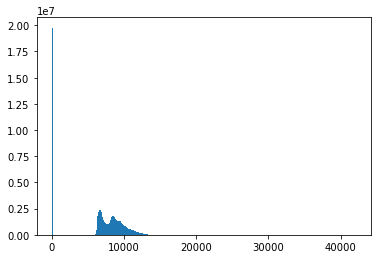

### Let's get rid of that black border (nodata values)
* Unlike most raster data you will encounter these days, the Landsat-8 images stored on the Google Cloud do not have a `nodata` value set in the image metadata
* As a result, when we read the raster to a NumPy array, the 0 values around the margins are consider valid pixels, and these appear black in our grayscale color ramp
* We have two options (read through both before starting):
    1. Set values of 0 to `np.nan`
        * Remember that `np.nan` is a special `float` object, so for this approach, you must first convert the entire array using `astype(float)`
            * This means we unnecessarily increase the amount of RAM required to store the same `UInt16` (2 byte) image DN values by a factor of 2x or 4x, as each `float32` value occupies 4 bytes, and the default NumPy `float` is actually `float64` or 8 bytes!  This increased memory requirement can be a real issue for large arrays. 
            * For this reason, I typically prefer to work with masked arrays (Option 2) for rasters with nodata.
        * Note that there are a growing number of "nan-aware" functions in NumPy (e.g., np.nanpercentile), but the options are still limited
        * Note that some packages like Pandas and xarray don't currently support masked ararys, but use `np.nan` for missing values
    2. Use a NumPy masked array (should be simple one-liner)
        * Take a few minutes to read about masked arrays
            * https://docs.scipy.org/doc/numpy/reference/maskedarray.generic.html#what-is-a-masked-array
            * https://docs.scipy.org/doc/numpy/reference/maskedarray.generic.html
            * Masked arrays allow for masking invalid values on any datatype (like `Byte` or `UInt16`)
                * Stores the mask as an additoinal 1-bit boolean array
        * See the `masked_equal` function to create a masked array from an existing array 
    * Note that you can also directly read a rasterio dataset (with NoData properly set) to a NumPy masked array with the `masked=True` argument of the `read()` function (e.g., `a = src.read(1, masked=True)`)
        * More info on rasterio nodata handling and more advanced masking support: https://rasterio.readthedocs.io/en/latest/topics/masks.html
* Preview your new array, inspect the mask
* Try plotting the masked array with imshow using the `gray` cmap
    * You should no longer see a black border around the valid pixels

### Replot the histogram of your masked array
* Remember to covert your 2D masked array to 1D with `ravel()` or the new masked array object method `compressed()` before running `hist()`
* There should no longer be a spike for the 0 bin

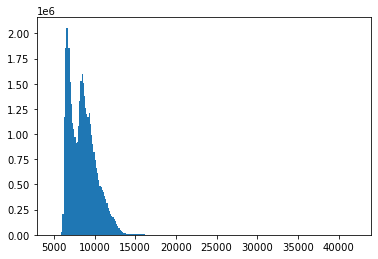

### Print the min and max values of masked array
* Note that 0 is not included!

### Determine the pixel DN values representing the 2nd and 98th percentile
* These percentile values are commonly used to set the vmin and vmax when plotting (e.g., in QGIS)
* Note that if you're using a masked array, you will need to isolate unmasked values using the `compressed()` method before passing to regular NumPy functions like `np.percentile`
* Plot these as vertical dotted black lines on your histogram
    * Hopefully this helps visualize what these percentile values represent based on your distribution.

[ 6304. 12415.]


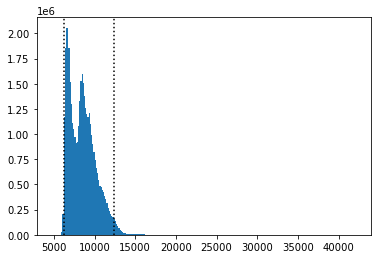

## Part 3: Raster transform
* Inspect the dataset `transform` attribute
* Review this: https://rasterio.readthedocs.io/en/stable/topics/georeferencing.html?highlight=affine#coordinate-transformation

Affine(30.0, 0.0, 473385.0,
       0.0, -30.0, 5373315.0)

### In your own words, what does this thing do? ✍️

### Calculate corner coordinates
* Use the transform to calculate the projected coordinates of the array corners
* Use the rasterio dataset `bounds` attribute to get the "truth" (you already did this)
* Creating tuples of array corner pixel coordinates (e.g. `[(0,0), (array.shape[1], 0), ...]`
    * Useful to think of corners as upper left, upper right, lower right, lower left
    * *Careful about mixing (rows, columns) and (x, y) coordinates!*
    * I recommend you draw a quick sketch for this exercise
* Use the affine transformation to convert to projected coordinates
    * This should be pretty easy to do - can directly multiply the Affine transform by the (x,y) coordinate tuple

array([[   0,    0],
       [   0, 7881],
       [7781,    0],
       [7781, 7881]])

array([[ 473385., 5373315.],
       [ 473385., 5136885.],
       [ 706815., 5373315.],
       [ 706815., 5136885.]])

I'm showing the above coordinates as arrays, but you can work with each corner individually

### Compute total dimensions of the projected raster dataset in km
* Use your bounds!
* Sanity check! Look up the actual LS-8 image footprint dimensions in km - make sure your calculated values are somewhat consistent. They may be different due to projection!

### Determine the array indices (row, column) of the center pixel in the image
* Try to use array attributes (like `shape`) here, instead of hardcoding values
* Note that we have an odd number of rows and columns in this array, so may need to round to nearest integer values

### Determine the DN value at this center pixel using array indexing
* Don't overthink this, just extract a value from the numpy array for the (row, col) indices you determined
    * You've done this kind of thing before, (e.g., `myarray[0,0]`)
* Make sure you are using integer values here (may need to convert/round), or NumPy will return an `IndexError`
* Do a sanity check on your interactive `imshow` plot above for DN values near the center of the image

### Determine the projected coordinates (meters in UTM 10N) of the center pixel
* Review the rasterio dataset `xy` method: https://rasterio.readthedocs.io/en/latest/api/rasterio.transform.html#rasterio.transform.TransformMethodsMixin.xy
    * Careful about the order of your row and column indices
* Sanity check the resulting projected coordinates with rasterio dataset `index` method - this should return your (row, col) indices
    * https://rasterio.readthedocs.io/en/latest/api/rasterio.transform.html#rasterio.transform.TransformMethodsMixin.index
    * These may be rounded to nearest integer
* These two functions allow you to go back and forth between the image/array coordiantes and the projected coordinate system!

### Extra Credit: sample the rasterio dataset (exctract the DN value) using these projected coordinates
* This doesn't require reading the array, but can be run on the src dataset for a list of (x,y) coordiantes
* See https://rasterio.readthedocs.io/en/latest/api/rasterio.sample.html
* Note that this will return an iterable generator, so will need to evaluate (can encompass in `list()` operator)
* The resulting DN value should be similar to the value you extracted directly from the array

### Now, apply what you've learned!
What is the DN value at the following projected coordinates:
* (522785.0, 5323315.0)
* (`src.bounds.left + 50000`, `src.bounds.top - 50000`)

522785.0 5323315.0
1666 1646


6843

## Part 4: Raster visualization with real-world coordinates and scalebar

### Extract the full-image `extent` in projected coordinates to pass to matplotlib imshow
* See doc on imshow `extent` parameter here: https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.imshow.html
* Note that the matplotlib `extent` is similar to the rasterio `bounds`, but not identical!
    * Be careful about ordering of (left, bottom, right, top) vs. (min_x, max_x, min_y, max_y)!
        * Good to practice, as this comes up often when working with rasters using different tools
    * There is also a convenience function to get the matplotlib `extent` for a rasterio Dataset: https://rasterio.readthedocs.io/en/latest/api/rasterio.plot.html#rasterio.plot.plotting_extent

In [ ]:
#This is rasterio bounds
src.bounds

BoundingBox(left=473385.0, bottom=5136885.0, right=706815.0, top=5373315.0)

In [ ]:
#This is matplotlib extent
full_extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
print(full_extent)

[473385.0, 706815.0, 5136885.0, 5373315.0]


In [ ]:
#rasterio convenience function
full_extent = rio.plot.plotting_extent(src)
print(full_extent)

(473385.0, 706815.0, 5136885.0, 5373315.0)


### Plot the image with `imshow`, but now pass in this `extent` as an argument
* Note how the axes coordinates change
    * These should now be meters in the UTM 10N coordinate system of the projected image!

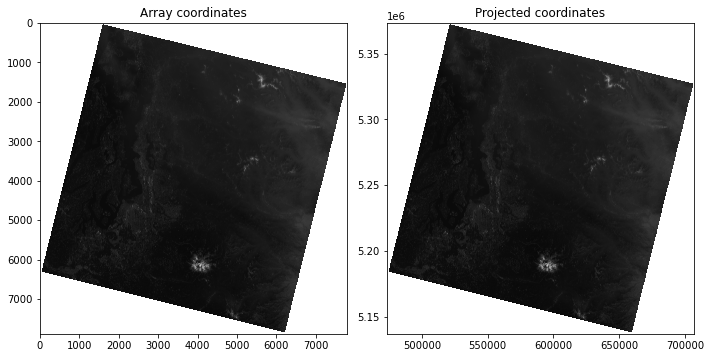

### Add a dynamic scalebar to the above plot
* We will use the `matplotlib-scalebar` package for this
* See documentation: https://github.com/ppinard/matplotlib-scalebar
> The constructor arguments dx and units specify the pixel dimension. For example scalebar = ScaleBar(0.2, 'um') indicates that each pixel is equal to 0.2 micrometer. If the the axes image has already been calibrated by setting its extent, set dx to 1.0.
    * In other words:
        * For imshow using array coordinates (without defining `extent`), use `ax.add_artist(ScaleBar(res))` where res is the pixel resolution in meters
        * For imshow using projected coordinates with `extent` defined, use `ax.add_artist(ScaleBar(1.0))` because one unit in the axes coordinate system is equal to 1 m
* If using interactive matplotlib backend, note what happens to the scalebar when you zoom

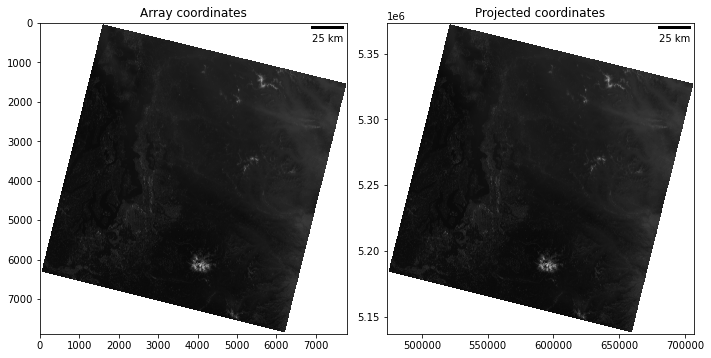

## Part 5: Raster window extraction

### Review: array indexing
* We could continue our analysis with the full images, but for many problems, we only care about a small subset of an image at any given time
* It's also a good practice to prototype new workflows using a small subset of data
    * Less memory usage, much faster processing, faster debugging
    * Remember this for your project!  
* One way to accomplish this might be to extract a portion of the large array using slicing/striding (see the Lab03 NumPy section)
    * Maybe a good time to review https://numpy.org/doc/stable/user/basics.indexing.html#slicing-and-striding
* To extract a 1024x1024 px chunk of the full-size array, we could do something like:

In [ ]:
r_masked.shape

(7881, 7781)

In [ ]:
chunk = r_masked[3000:4024,3000:4024]

In [ ]:
chunk.shape

(1024, 1024)

### Extra Credit: extract a 256x256 pixel window around the center pixel of the array
* You already determined the center pixel indices earlier
* You'll need to define the appropriate slices for both rows and columns
    * Try to define window dimensions and corresponding slices using variables, rather than hardcoding 256 or 128
* Preview the resulting 256x256 pixel array

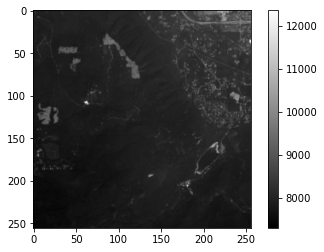

## Nice Job. Proceed to Notebook #2!
* We'll pick up with rasterio `window` functionality to extract windows directly from the original tif files, then do all kinds of cool stuff with the resulting arrays